In [2]:
import pandas as pd
import numpy as np

df_all = pd.read_csv("../data/VehicleCrash.csv", delimiter=';')
df_all.head()

,Weight,Acceleration,Intrusion,x1,x2,x3,x4,x5,Feasible
0,1661.707823,8.304600,0.070800,1.000000,1.000000,1.000000,1.000000,1.000000,1
1,1682.274517,6.655020,0.195663,1.017626,2.978655,2.668588,1.000037,2.864213,1
2,1662.591855,8.045753,0.089807,1.000003,1.380717,1.000000,1.000000,1.000000,1
3,1675.489595,6.142803,0.264000,1.000005,3.000000,3.000000,1.000000,1.000000,1
4,1686.660654,9.503282,0.047653,2.875087,3.000000,1.000000,1.903562,3.000000,1


In [3]:
variable_names = [f"x{i}" for i in range(1, 6)]

feasible = df_all["Feasible"].values == 1
fs = df_all[["Weight", "Acceleration", "Intrusion"]].loc[feasible].copy().reset_index(drop=True)
xs = df_all[variable_names].loc[feasible].copy().reset_index(drop=True)

print(fs.head())
print(xs.head())

        Weight  Acceleration  Intrusion
0  1661.707823      8.304600   0.070800
1  1682.274517      6.655020   0.195663
2  1662.591855      8.045753   0.089807
3  1675.489595      6.142803   0.264000
4  1686.660654      9.503282   0.047653
         x1        x2        x3        x4        x5
0  1.000000  1.000000  1.000000  1.000000  1.000000
1  1.017626  2.978655  2.668588  1.000037  2.864213
2  1.000003  1.380717  1.000000  1.000000  1.000000
3  1.000005  3.000000  3.000000  1.000000  1.000000
4  2.875087  3.000000  1.000000  1.903562  3.000000


In [4]:
""" Category 1 -- Knee: Weight <= 1685 & Acceleration <= 8.5 & Intrusion <= 0.10
    Category 2 -- F1Extreme: Weight >= 1695
    Category 3 -- F2Extreme: Acceleration >= 10.5 & Weight <= 1685
    Category 4 -- F3Extreme: Intrusion >= 0.20
    Category 5 -- Dominated: Acceleration >= 9.0 & Intrusion >= 0.15
"""

# Category 1
c1_mask = np.logical_and(fs["Weight"] <= 1685, fs["Acceleration"] <= 8.5, fs["Intrusion"] <= 0.10)
# Category 2
c2_mask = fs["Weight"] >= 1695
# Category 3
c3_mask = np.logical_and(fs["Acceleration"] >= 10.5, fs["Weight"] <= 1685)
# Category 4
c4_mask = fs["Intrusion"] >= 0.20
# Category 5
c5_mask = np.logical_and(fs["Acceleration"] >= 9.0, fs["Intrusion"] >= 0.15)

xs.loc[c1_mask, "category"] = 1
xs.loc[c2_mask, "category"] = 2
xs.loc[c3_mask, "category"] = 3
xs.loc[c4_mask, "category"] = 4
xs.loc[c5_mask, "category"] = 5

xs_clean = xs[~xs["category"].isnull()]
xs_clean.head()

,x1,x2,x3,x4,x5,category
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
1,1.017626,2.978655,2.668588,1.000037,2.864213,1.0
2,1.000003,1.380717,1.000000,1.000000,1.000000,1.0
3,1.000005,3.000000,3.000000,1.000000,1.000000,4.0
8,1.000356,1.017699,1.000000,1.000006,2.809271,1.0


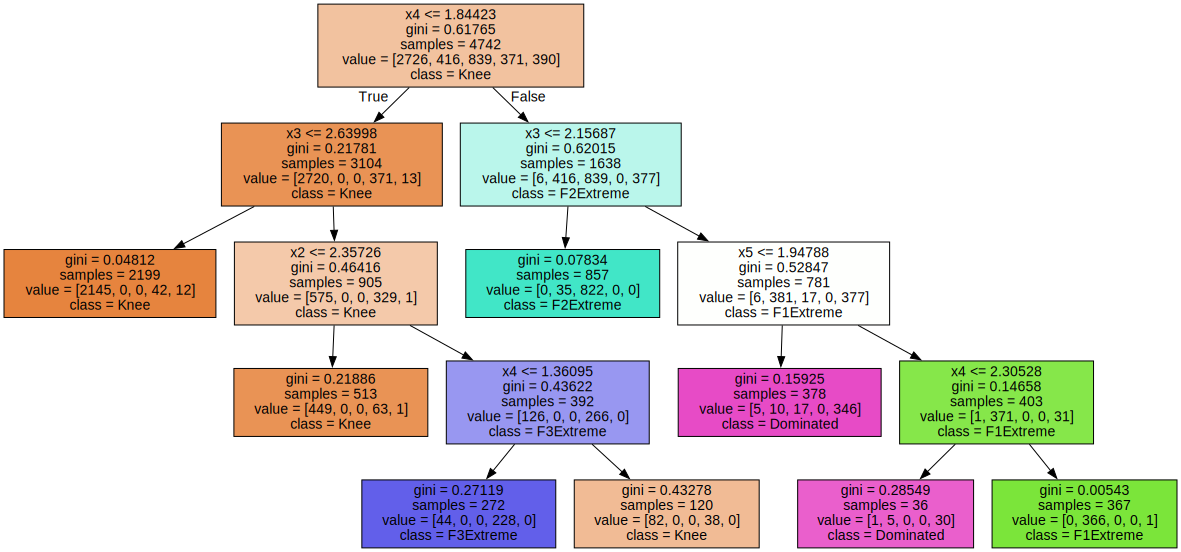

In [5]:
from sklearn import tree
Classifier = tree.DecisionTreeClassifier
from imodels.discretization import ExtraBasicDiscretizer as Discretizer
import graphviz

classifier = Classifier(max_leaf_nodes=8)
classifier.fit(xs_clean[variable_names], xs_clean["category"])

dot_data = tree.export_graphviz(classifier, out_file=None, 
                     feature_names=variable_names,  
                     class_names=["Knee", "F1Extreme", "F2Extreme", "F3Extreme", "Dominated"],  
                     filled=True, rounded=False, precision=5,  
                     special_characters=False)  
graph = graphviz.Source(dot_data)  
graph 